In [1]:
!pip install fastai
!pip install boto3
!pip install tqdm
!pip install timm
!pip install wandb
!pip install split-folders
!pip install gdown --upgrade
!pip install fastai==2.5.2 fastcore==1.3.26
!pip install torch==1.9.0+cu111 torchvision==0.10.0+cu111 torchaudio==0.9.0 -f https://download.pytorch.org/whl/torch_stable.html

Looking in links: https://download.pytorch.org/whl/torch_stable.html


In [7]:
!gdown "https://drive.google.com/drive/folders/1Q0UggEsjl2No375KHtbv-oYBmhzXn7Og?usp=sharing -O /tmp/folder --folder"

C:\Users\ArrunPersonal\anaconda3\lib\site-packages\gdown\parse_url.py:35: UserWarning: You specified a Google Drive link that is not the correct link to download a file. You might want to try `--fuzzy` option or the following url: https://drive.google.com/uc?id=None
  warnings.warn(
Downloading...
From: https://drive.google.com/drive/folders/1Q0UggEsjl2No375KHtbv-oYBmhzXn7Og?usp=sharing -O /tmp/folder --folder
To: C:\Users\ArrunPersonal\Codes\SceneRecognition Remote Sensing\CodeBase_Ultimate\folder --folder

0.00B [00:00, ?B/s]
207kB [00:00, 1.81MB/s]
453kB [00:00, 2.15MB/s]
860kB [00:00, 2.97MB/s]


In [8]:
!unzip "C:/Users/ArrunPersonal/Codes/SceneRecognition Remote Sensing/RSI-CB256.zip"

'unzip' is not recognized as an internal or external command,
operable program or batch file.


In [1]:
from PIL import Image
import os

In [11]:
import splitfolders
splitfolders.ratio("C:/Users/ArrunPersonal/Codes/SceneRecognition Remote Sensing/RSI-CB256", output="C:/Users/ArrunPersonal/Codes/SceneRecognition Remote Sensing/RSI-CB256_splitted",seed=42, ratio=(.8,.2), group_prefix=None, move=False) # default values

Copying files: 24717 files [01:28, 280.20 files/s]


In [2]:
from fastai.vision.all import *
import timm
#from fastai.distributed import *
import warnings
warnings.simplefilter("ignore")

In [3]:
def random_seed(seed_value, use_cuda):
    np.random.seed(seed_value) # cpu vars
    torch.manual_seed(seed_value) # cpu  vars
    random.seed(seed_value) # Python
    os.environ['PYTHONHASHSEED'] = str(seed_value)
    if use_cuda: 
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value) # gpu vars
        torch.backends.cudnn.deterministic = True  #needed
        torch.backends.cudnn.benchmark = False

random_seed(42, True)

In [4]:
def create_cls_module(nf, n_out, lin_ftrs=None, ps=0.5, use_bn=False, first_bn=False, bn_final=False, lin_first=False, y_range=None):
    "Creates classification layer which takes nf flatten features and outputs n_out logits"
    lin_ftrs = [nf, 512, n_out] if lin_ftrs is None else [nf] + lin_ftrs + [n_out]
    bns = [first_bn] + [use_bn]*len(lin_ftrs[1:])
    ps = L(ps)
    if len(ps) == 1: ps = [ps[0]/2] * (len(lin_ftrs)-2) + ps
    actns = [nn.ReLU(inplace=True)] * (len(lin_ftrs)-2) + [None]
    layers = []
    if lin_first: layers.append(nn.Dropout(ps.pop(0)))
    for ni,no,bn,p,actn in zip(lin_ftrs[:-1], lin_ftrs[1:], bns, ps, actns):
        layers += LinBnDrop(ni, no, bn=bn, p=p, act=actn, lin_first=lin_first)
    if lin_first: layers.append(nn.Linear(lin_ftrs[-2], n_out))
    if bn_final: layers.append(nn.BatchNorm1d(lin_ftrs[-1], momentum=0.01))
    if y_range is not None: layers.append(SigmoidRange(*y_range))
    return nn.Sequential(*layers)

In [5]:
path = r'C:/Users/ArrunPersonal/Codes/SceneRecognition Remote Sensing/RSI-CB256_splitted'
bs = 16
sz = 64

data = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    get_y= parent_label,
    splitter= GrandparentSplitter(train_name = "train",valid_name = "val"))#,
    #item_tfms=Resize(460),
    #batch_tfms=aug_transforms(mult=1.0, do_flip=True, flip_vert=True, max_rotate=120.0, min_zoom=1.0, max_zoom=1.1, max_lighting=0.2, max_warp=0.2, p_affine=0.75, p_lighting=0.75, xtra_tfms=None, size=64, mode='bilinear', pad_mode='reflection', align_corners=True, batch=False, min_scale=1.0))

In [6]:
dls = data.dataloaders(path, bs=bs)
print("Number of classes: ",dls.c)

Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck
Number of classes:  35


In [14]:
arch = "swin_base_patch4_window7_224_in22k"
model = timm.create_model(arch, pretrained=True, in_chans=3, num_classes=0)

In [16]:
model

SwinTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 128, kernel_size=(4, 4), stride=(4, 4))
    (norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (layers): Sequential(
    (0): BasicLayer(
      dim=128, input_resolution=(56, 56), depth=2
      (blocks): ModuleList(
        (0): SwinTransformerBlock(
          (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
          (attn): WindowAttention(
            (qkv): Linear(in_features=128, out_features=384, bias=True)
            (attn_drop): Dropout(p=0.0, inplace=False)
            (proj): Linear(in_features=128, out_features=128, bias=True)
            (proj_drop): Dropout(p=0.0, inplace=False)
            (softmax): Softmax(dim=-1)
          )
          (drop_path): Identity()
          (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
          (mlp): Mlp(
            (fc1): Linear(in_features=128, out_features=512, bias=True)
     

In [15]:
len(dict(model.named_modules()))

410

In [19]:
model.fc = nn.Sequential(create_cls_module(nf=model.num_features, n_out=dls.c))

In [20]:
savedfilename = f'{path}_{arch}'
learn = Learner(dls, model, metrics=[accuracy,Precision(average='macro'), Recall(average='macro'), F1Score(average='macro')],  cbs=[CSVLogger(fname=savedfilename+'.csv', append=True),
                         SaveModelCallback(monitor='valid_loss', comp=None, min_delta=0.0,fname=savedfilename, every_epoch=False, with_opt=False, reset_on_fit=True)])#.to_fp16()

In [21]:
learn.summary()

ResNet (Input shape: 16)
Layer (type)         Output Shape         Param #    Trainable 
                     16 x 64 x 128 x 128 
Conv2d                                    9408       True      
BatchNorm2d                               128        True      
ReLU                                                           
MaxPool2d                                                      
Conv2d                                    4096       True      
BatchNorm2d                               128        True      
ReLU                                                           
Conv2d                                    36864      True      
BatchNorm2d                               128        True      
ReLU                                                           
____________________________________________________________________________
                     16 x 256 x 64 x 64  
Conv2d                                    16384      True      
BatchNorm2d                               512 

SuggestedLRs(valley=0.0004786300996784121)

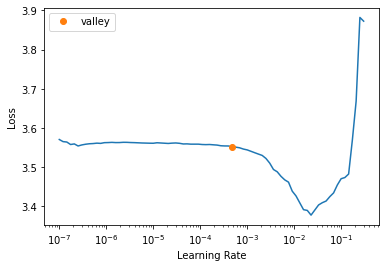

In [22]:
learn.lr_find()

## VGG-16

In [1]:
!python -m fastai.launch "arun_classifier_custom_fastai_vgg16.py"

Number of classes:  19
Number of classes:  19
epoch     train_loss  valid_loss  accuracy  precision_score  recall_score  f1_score  time    
0         2.835598    2.678948    0.427184  0.393034         0.430542      0.349233  01:30     
Better model found at epoch 0 with valid_loss value: 2.678948163986206.
Better model found at epoch 0 with valid_loss value: 2.678948163986206.
1         2.462350    1.411990    0.684466  0.751028         0.686615      0.679044  01:27     
Better model found at epoch 1 with valid_loss value: 1.4119898080825806.
Better model found at epoch 1 with valid_loss value: 1.4119898080825806.
Better model found at epoch 2 with valid_loss value: 0.643441379070282.
2         1.803393    0.643441    0.791262  0.831200         0.795651      0.787443  01:33     
Better model found at epoch 2 with valid_loss value: 0.643441379070282.
Better model found at epoch 3 with valid_loss value: 0.3560324013233185.
3         1.256634    0.356032    0.868932  0.884300         0.87

## Resnet50

In [4]:
!python -m fastai.launch "arun_classifier_custom_fastai_resnet50.py"

Number of classes:  35
epoch     train_loss  valid_loss  accuracy  precision_score  recall_score  f1_score  time    
Number of classes:  35
epoch     train_loss  valid_loss  accuracy  precision_score  recall_score  f1_score  time    


THCudaCheck FAIL file=..\torch/csrc/generic/StorageSharing.cpp line=258 error=801 : operation not supported
Traceback (most recent call last):
  File "C:\Users\ArrunPersonal\Codes\SceneRecognition Remote Sensing\CodeBase_Ultimate\arun_classifier_custom_fastai_resnet50.py", line 68, in <module>
    learn.fit_flat_cos(30, 3e-4)
  File "C:\Users\ArrunPersonal\anaconda3\lib\site-packages\fastai\callback\schedule.py", line 136, in fit_flat_cos
    self.fit(n_epoch, cbs=ParamScheduler(scheds)+L(cbs), reset_opt=reset_opt, wd=wd)
  File "C:\Users\ArrunPersonal\anaconda3\lib\site-packages\fastai\learner.py", line 221, in fit
    self._with_events(self._do_fit, 'fit', CancelFitException, self._end_cleanup)
  File "C:\Users\ArrunPersonal\anaconda3\lib\site-packages\fastai\learner.py", line 163, in _with_events
    try: self(f'before_{event_type}');  f()
  File "C:\Users\ArrunPersonal\anaconda3\lib\site-packages\fastai\learner.py", line 212, in _do_fit
    self._with_events(self._do_epoch, 'epoch'

## EfficientNetB3

In [14]:
!python -m fastai.launch "arun_classifier_custom_fastai_effncientnet_b3.py"

Number of classes:  31
Number of classes:  31
epoch     train_loss  valid_loss  accuracy  precision_score  recall_score  f1_score  time    
0         2.899540    1.857604    0.696237  0.768795         0.696237      0.676077  00:43     
Better model found at epoch 0 with valid_loss value: 1.8576041460037231.
Better model found at epoch 0 with valid_loss value: 1.8576041460037231.
Better model found at epoch 1 with valid_loss value: 0.4419417381286621.
1         1.570499    0.441942    0.884409  0.894951         0.884409      0.883893  00:44     
Better model found at epoch 1 with valid_loss value: 0.4419417381286621.
2         0.930453    0.303775    0.930108  0.939273         0.930108      0.930006  00:44     
Better model found at epoch 2 with valid_loss value: 0.30377528071403503.
Better model found at epoch 2 with valid_loss value: 0.30377528071403503.
3         0.531346    0.240020    0.927419  0.936796         0.927419      0.928031  00:43     
Better model found at epoch 3 with v

## ViT Base 224

In [2]:
!python -m fastai.launch "arun_classifier_custom_fastai_vit_base_patch16_224.py"

Number of classes:  31
Number of classes:  31
epoch     train_loss  valid_loss  accuracy  precision_score  recall_score  f1_score  time    
Better model found at epoch 0 with valid_loss value: 1.1279934644699097.
0         2.320258    1.127993    0.698925  0.776386         0.698925      0.676866  01:36     
Better model found at epoch 0 with valid_loss value: 1.1279934644699097.
1         0.917351    0.489750    0.849462  0.891960         0.849462      0.838392  01:33     
Better model found at epoch 1 with valid_loss value: 0.4897502064704895.
Better model found at epoch 1 with valid_loss value: 0.4897502064704895.
2         0.382679    0.264705    0.924731  0.940174         0.924731      0.923400  01:33     
Better model found at epoch 2 with valid_loss value: 0.26470547914505005.
Better model found at epoch 2 with valid_loss value: 0.26470547914505005.
Better model found at epoch 3 with valid_loss value: 0.18886975944042206.
3         0.207155    0.188870    0.943548  0.948784      

## Swin_base_224

In [5]:
!python -m fastai.launch "arun_classifier_custom_fastai_swin_base.py"

Number of classes:  31
Number of classes:  31
Downloading: "https://github.com/SwinTransformer/storage/releases/download/v1.0.0/swin_base_patch4_window7_224_22k.pth" to /home/.cache/torch/hub/checkpoints/swin_base_patch4_window7_224_22k.pth
Downloading: "https://github.com/SwinTransformer/storage/releases/download/v1.0.0/swin_base_patch4_window7_224_22k.pth" to /home/.cache/torch/hub/checkpoints/swin_base_patch4_window7_224_22k.pth
epoch     train_loss  valid_loss  accuracy  precision_score  recall_score  f1_score  time    
0         2.911164    1.971535    0.666667  0.746425         0.666667      0.656205  00:56     
Better model found at epoch 0 with valid_loss value: 1.9715346097946167.
Better model found at epoch 0 with valid_loss value: 1.9715346097946167.
Better model found at epoch 1 with valid_loss value: 0.6243441700935364.
1         1.515444    0.624344    0.884409  0.899156         0.884409      0.884867  00:56     
Better model found at epoch 1 with valid_loss value: 0.6243

## ConvNextBase

In [8]:
!python -m fastai.launch "arun_classifier_custom_fastai_convnext.py"

Number of classes:  31
Number of classes:  31
epoch     train_loss  valid_loss  accuracy  precision_score  recall_score  f1_score  time    
[W reducer.cpp:283] Warning: Grad strides do not match bucket view strides. This may indicate grad was not created according to the gradient layout contract, or that the param's strides changed since DDP was constructed.  This is not an error, but may impair performance.
grad.sizes() = [1536, 1, 7, 7], strides() = [49, 1, 7, 1]
bucket_view.sizes() = [1536, 1, 7, 7], strides() = [49, 49, 7, 1] (function operator())
[W reducer.cpp:283] Warning: Grad strides do not match bucket view strides. This may indicate grad was not created according to the gradient layout contract, or that the param's strides changed since DDP was constructed.  This is not an error, but may impair performance.
grad.sizes() = [1536, 1, 7, 7], strides() = [49, 1, 7, 1]
bucket_view.sizes() = [1536, 1, 7, 7], strides() = [49, 49, 7, 1] (function operator())
Better model found at ep

In [19]:
timm.list_models("swin*",pretrained=True)

['swin_base_patch4_window7_224',
 'swin_base_patch4_window7_224_in22k',
 'swin_base_patch4_window12_384',
 'swin_base_patch4_window12_384_in22k',
 'swin_large_patch4_window7_224',
 'swin_large_patch4_window7_224_in22k',
 'swin_large_patch4_window12_384',
 'swin_large_patch4_window12_384_in22k',
 'swin_small_patch4_window7_224',
 'swin_tiny_patch4_window7_224']

In [14]:
timm.list_models("convnext*",pretrained=True)

['convnext_base',
 'convnext_base_384_in22ft1k',
 'convnext_base_in22ft1k',
 'convnext_base_in22k',
 'convnext_large',
 'convnext_large_384_in22ft1k',
 'convnext_large_in22ft1k',
 'convnext_large_in22k',
 'convnext_small',
 'convnext_tiny',
 'convnext_xlarge_384_in22ft1k',
 'convnext_xlarge_in22ft1k',
 'convnext_xlarge_in22k']